In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import talib

plt.style.use('ggplot')

# 資料載入

In [2]:
df = pd.read_csv('TWF_Futures_Minute_Trade.txt')
df

,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [3]:
settlementDate_ = pd.read_csv('settlementDate.csv', encoding = 'big5')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/8/31,202208W5,15078
1,2022/8/24,202208W4,15097
2,2022/8/17,202208,15452
3,2022/8/10,202208W2,14945
4,2022/8/3,202208W1,14707
...,...,...,...
512,2009/12/16,200912,7752
513,2009/11/18,200911,7786
514,2009/10/21,200910,7705
515,2009/9/16,200909,7445


In [4]:
ftr = pd.read_csv('foi&pc_ratio.csv')
ftr.index = pd.to_datetime(ftr.Date)
ftr = ftr.drop(columns = ['Date'])
ftr

,外資未平倉,PC ratio
Date,,
2007-07-02,-6558,94.00
2007-07-03,-7244,99.37
2007-07-04,-10093,107.74
2007-07-05,-11282,112.52
2007-07-06,-11925,115.57
...,...,...
2022-06-06,8528,105.68
2022-06-07,6617,99.09
2022-06-08,9587,107.31


# 資料處裡

資料處裡

In [5]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [6]:
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [7]:
Morning=Morning.drop(columns=['Hour'])
daily = Morning.resample("B").agg(dict(zip(Morning.columns,["first", "max", "min", "last", "sum"])))
daily = daily[daily["close"].isna()==False].copy()
daily

,open,high,low,close,volume
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382
...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478


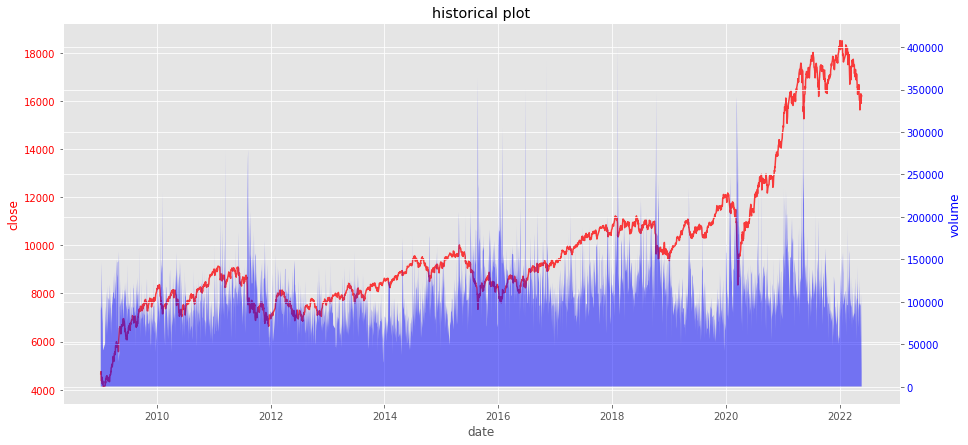

In [8]:
fig, ax1 = plt.subplots(figsize = (15,7))
plt.title('historical plot')
plt.xlabel('date')
ax2 = ax1.twinx()
ax1.set_ylabel('close', color='red')
ax1.plot(daily.close, color='red', alpha=0.75)
ax1.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('volume', color='blue')
ax2.fill_between(daily.index, daily.volume, 100, facecolor  = 'blue', label = 'volume', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='blue')

In [9]:
daily = pd.concat([daily, ftr], axis = 1, join = 'inner').dropna()
daily = daily.rename(columns = dict(zip(daily.columns, ['Open', 'High', 'Low', 'Close', 'Volume','Foreign_OI','PC_ratio']))) 
daily

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869,11435,66.79
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227,12294,68.42
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777,14821,70.11
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219,15009,64.57
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382,18302,64.13
...,...,...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


切分訓練集和測試集

In [15]:
trainData = daily[(daily.index >= '2010-01-01 00:00:00') & (daily.index <= '2019-06-30 00:00:00')].copy()
testData = daily[(daily.index >= '2019-07-01 00:00:00') & (daily.index <= '2022-5-22 00:00:00')].copy()

In [11]:
trainData.head(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2010-01-04,8203.0,8211.0,8101.0,8166.0,83881,2645,130.80
2010-01-05,8212.0,8260.0,8125.0,8178.0,107583,2356,127.23
2010-01-06,8197.0,8336.0,8179.0,8320.0,119934,3990,138.49
2010-01-07,8335.0,8355.0,8230.0,8259.0,120490,-3326,137.58
2010-01-08,8287.0,8297.0,8183.0,8278.0,104767,-4730,137.68


In [12]:
testData.tail(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948,-2540,89.74
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


結算日

In [13]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]
settlementDate[-5:]

[datetime.date(2009, 12, 16),
 datetime.date(2009, 11, 18),
 datetime.date(2009, 10, 21),
 datetime.date(2009, 9, 16),
 datetime.date(2009, 8, 19)]

# 回測

In [14]:
fund = 1000000
feePaid = 600
K = 0.04
d = 0.02
pc_h = 110
pc_l = 90

In [21]:
trainData['v_max'] = trainData.Volume.rolling(10).max()
trainData['sma13'] = talib.EMA((trainData.High+trainData.Low)/2, 13).shift(8)
trainData['sma8'] = talib.EMA((trainData.High+trainData.Low)/2, 8).shift(5)
trainData['sma5'] = talib.EMA((trainData.High+trainData.Low)/2, 5).shift(3)

In [22]:
trainData.head(20)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio,v_max,sma13,sma8,sma5
2010-01-04,8203.0,8211.0,8101.0,8166.0,83881,2645,130.80,NaN,NaN,NaN,NaN
2010-01-05,8212.0,8260.0,8125.0,8178.0,107583,2356,127.23,NaN,NaN,NaN,NaN
2010-01-06,8197.0,8336.0,8179.0,8320.0,119934,3990,138.49,NaN,NaN,NaN,NaN
2010-01-07,8335.0,8355.0,8230.0,8259.0,120490,-3326,137.58,NaN,NaN,NaN,NaN
2010-01-08,8287.0,8297.0,8183.0,8278.0,104767,-4730,137.68,NaN,NaN,NaN,NaN
2010-01-11,8278.0,8353.0,8251.0,8321.0,87475,-2283,140.66,NaN,NaN,NaN,NaN
2010-01-12,8318.0,8337.0,8246.0,8308.0,99457,-3338,140.51,NaN,NaN,NaN,NaN
2010-01-13,8259.0,8275.0,8191.0,8215.0,108400,-6097,134.69,NaN,NaN,NaN,8227.700000
2010-01-14,8246.0,8328.0,8236.0,8301.0,80657,-6131,136.96,NaN,NaN,NaN,8252.466667
2010-01-15,8310.0,8385.0,8307.0,8369.0,95385,-6685,140.35,120490.0,NaN,NaN,8265.477778


In [23]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

              profit  profitfee
2010-01-04       0.0        0.0
2010-01-05       0.0        0.0
2010-01-06       0.0        0.0
2010-01-07       0.0        0.0
2010-01-08       0.0        0.0
...              ...        ...
2019-06-24  118400.0    38000.0
2019-06-25  118400.0    38000.0
2019-06-26  118400.0    38000.0
2019-06-27  118400.0    38000.0
2019-06-28  118400.0    38000.0

[2319 rows x 2 columns]


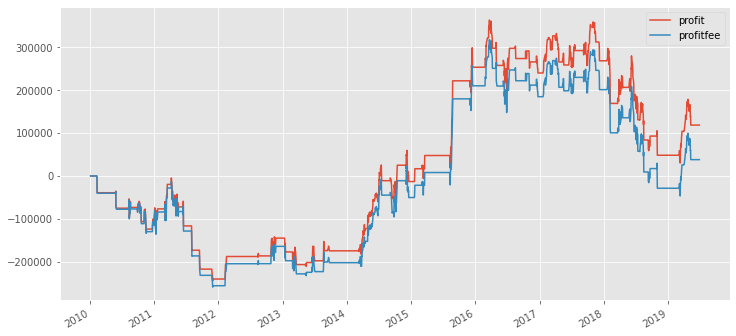

In [35]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong =  (df_arr[i,4] == df_arr[i,7]) & (df_arr[i,8] < df_arr[i,9]) & (df_arr[i,9] < df_arr[i,10]) & (df_arr[i,6] >= 110)
    entrySellShort = (df_arr[i,4] == df_arr[i,7]) & (df_arr[i,8] > df_arr[i,9]) & (df_arr[i,9] > df_arr[i,10]) & (df_arr[i,6] <= 90)
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = (df_arr[i,3] < df_arr[i,8]) & (df_arr[i,6] <= 90)
    exitBuyToCover = (df_arr[i,3] > df_arr[i,8]) & (df_arr[i,6] >= 110)
    exitCondition = date_arr[i] in settlementDate  ####
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

In [36]:
print(buy)
print(sell)
print(sellshort)
print(buytocover)

[145, 180, 207, 240, 308, 322, 353, 388, 514, 642, 749, 773, 822, 909, 1025, 1036, 1059, 1077, 1096, 1148, 1210, 1242, 1267, 1507, 1520, 1522, 1546, 1576, 1582, 1620, 1658, 1672, 1702, 1729, 1743, 1769, 1796, 1820, 1828, 1880, 1892, 1914, 1938, 1972, 2006, 2010, 2050, 2091, 2125, 2239, 2258, 2270]
[154, 195, 217, 262, 317, 337, 356, 391, 522, 646, 753, 788, 827, 914, 1033, 1052, 1076, 1095, 1115, 1156, 1222, 1245, 1278, 1516, 1521, 1534, 1551, 1581, 1597, 1624, 1664, 1676, 1709, 1739, 1760, 1783, 1802, 1825, 1845, 1890, 1907, 1927, 1942, 1985, 2009, 2026, 2069, 2109, 2134, 2251, 2269, 2284]
[25, 94, 283, 420, 469, 695, 847, 855, 892, 1161, 1374, 1384, 1453, 2073, 2159]
[27, 97, 294, 422, 473, 715, 851, 858, 895, 1175, 1383, 1386, 1465, 2085, 2162]


In [37]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

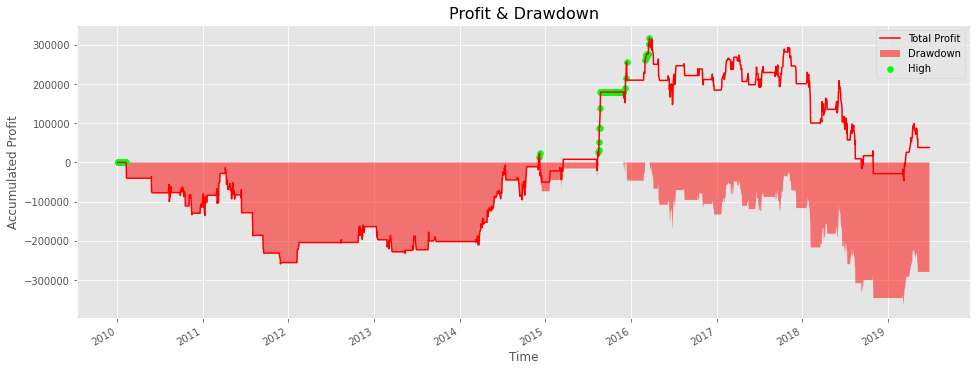

In [38]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

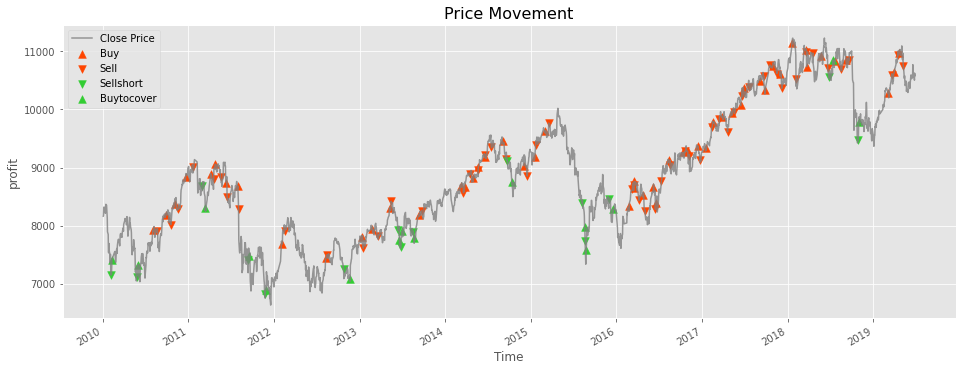

In [39]:
fig, ax = plt.subplots(figsize = (16,6))

trainData['Close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(trainData['Close'].iloc[buy].index, trainData['Close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(trainData['Close'].iloc[sell].index, trainData['Close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[sellshort].index, trainData['Close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[buytocover].index, trainData['Close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('profit')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [40]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $38000.0
return: 3.8%
mdd: 27.62%
calmarRatio: 0.14
tradeTimes: 67
winRate: 49.25%
profitFactor: 1.03
winLossRatio: 1.06
